In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Declare a Base using `automap_base()`
Base = automap_base()

In [7]:
# reflect an existing database into a new model and reflect the tables
Base.prepare(engine, reflect=True)


In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date_datetime = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_prior = str(most_recent_date_datetime.replace(year=most_recent_date_datetime.year-1).date())
one_year_prior

'2016-08-23'

In [92]:
# Perform a query to retrieve the data and precipitation scores
ytd_precp = session.query(measurement.date, func.max(measurement.prcp).label('prcp')).\
    filter(measurement.date >= one_year_prior).\
    group_by(measurement.date).order_by(measurement.date).statement

In [93]:
# Save the query results as a Pandas DataFrame and set the index to the date column
ytd_precp_df = pd.read_sql(ytd_precp, session.bind)

#.set_index('date')
ytd_precp_df.head()

,date,prcp
0,2016-08-23,1.79
1,2016-08-24,2.28
2,2016-08-25,0.21
3,2016-08-26,0.04
4,2016-08-27,0.18


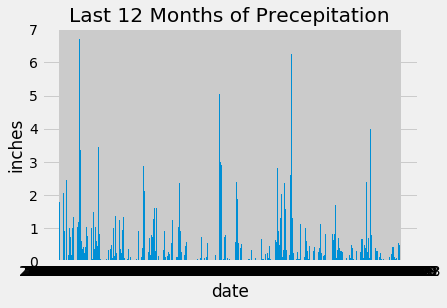

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots()
ax.bar(ytd_precp_df['date'],ytd_precp_df['prcp'])
ax.set_xlabel("date")
ax.set_ylabel("inches")
ax.set_title("Last 12 Months of Precepitation")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_summary_stats = ytd_precp_df.describe()
prec_summary_stats

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


In [101]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.station).count()
station_count

9

In [ ]:
session.query(station.station)

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station).label('count'))\
                    .group_by(measurement.station).order_by(func.count(measurement.station).desc()).statement

station_activity_df = pd.read_sql(most_active_stations, session.bind) 
station_activity_df

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = station_activity_df.iloc[0,0]
most_active_station

'USC00519281'

In [49]:
# calculate the lowest, highest and avg temperatures recorded
temp_analysis = session.query(measurement.station, func.min(measurement.tobs).label('lowest temp'),\
    func.max(measurement.tobs).label('highest temp'),\
    func.avg(measurement.tobs).label('average temp')\
    ).filter(measurement.station == most_active_station).statement

In [48]:
# place data into data frame for readability
temp_analysis_df = pd.read_sql(temp_analysis, session.bind)
temp_analysis_df

,station,lowest temp,highest temp,average temp
0,USC00519281,54.0,85.0,71.663781


In [62]:
# Choose the station with the highest number of temperature observations.
most_temp_activity = session.query(measurement.station, func.count(measurement.tobs).label('count')).\
                    filter(measurement.tobs.isnot(None))\
                    .group_by(measurement.station).order_by(func.count(measurement.tobs).desc()).first()[0]
most_temp_activity

'USC00519281'

In [75]:
# Query the last 12 months of temperature observation data for this station 
temp_data = session.query(func.max(measurement.tobs).label('highest_temp')).\
    filter(measurement.date >= one_year_prior).\
    filter(measurement.station == most_temp_activity).\
    group_by(measurement.date).order_by(measurement.date).statement
    
temp_data_df = pd.read_sql(temp_data, session.bind)
temp_data_df.head()

,highest_temp
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


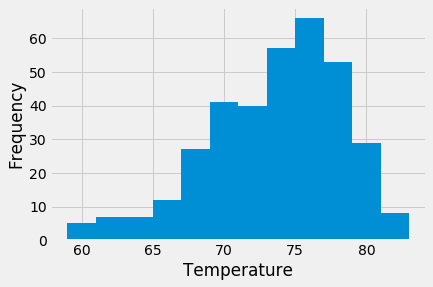

In [81]:
# Plot the results as a histogram
plt.hist(temp_data_df.highest_temp, bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
